Paper Reference : https://j-innovative.org/index.php/Innovative/article/download/15199/10372/26113

In [1]:
import os
from modules.SignLanguageProcessor import load_and_preprocess_data,parse_frame

In [2]:
ROOT_PATH = ''
sequences,labels,label_map = load_and_preprocess_data(os.path.join(ROOT_PATH,'data'))

In [3]:
num_classes = len(label_map)

In [4]:
len(labels)

1722

In [5]:
sequences.shape

(1722, 3, 61, 3)

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(
    sequences, labels, test_size=0.4, stratify=labels, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)


In [7]:
import numpy as np
def normalize_landmark_data(X):
    """
    Normalize the landmark features (x, y) to have zero mean and unit variance across the training set.
    Assumes X shape is (N, F, L, T), where F=3 (x, y, vis).
    """
    X = X.copy()
    # Flatten across all samples, landmarks, and frames
    x_vals = X[:, 0, :, :].flatten()
    y_vals = X[:, 1, :, :].flatten()

    # Compute mean and std
    x_mean, x_std = np.mean(x_vals), np.std(x_vals)
    y_mean, y_std = np.mean(y_vals), np.std(y_vals)

    # Normalize
    X[:, 0, :, :] = (X[:, 0, :, :] - x_mean) / x_std
    X[:, 1, :, :] = (X[:, 1, :, :] - y_mean) / y_std

    return X, (x_mean, x_std), (y_mean, y_std)

def apply_normalization(X, x_mean, x_std, y_mean, y_std):
    X = X.copy()
    X[:, 0, :, :] = (X[:, 0, :, :] - x_mean) / x_std
    X[:, 1, :, :] = (X[:, 1, :, :] - y_mean) / y_std
    return X


In [8]:
def reshape_frames_for_cnn(X, y):
    """
    Reshape a dataset of (N, F, L, T) into (N*T, L, F, 1) for Conv2D,
    where each frame becomes its own sample.

    Parameters:
    - X: np.ndarray of shape (N, F, L, T)
    - y: np.ndarray of shape (N,)

    Returns:
    - reshaped_X: np.ndarray of shape (N*T, L, F, 1)
    - reshaped_y: np.ndarray of shape (N*T,)
    """
    reshaped_X = []
    reshaped_y = []

    for sample, label in zip(X, y):
        T = sample.shape[-1]
        for t in range(T):
            frame = sample[:, :, t].T[..., np.newaxis] 
            reshaped_X.append(frame)
            reshaped_y.append(label)

    reshaped_X = np.array(reshaped_X)
    reshaped_y = np.array(reshaped_y)
    return reshaped_X, reshaped_y

In [9]:

X_train_norm, (x_mean, x_std), (y_mean, y_std) = normalize_landmark_data(X_train)
X_val_norm  = apply_normalization(X_val, x_mean, x_std, y_mean, y_std)
X_test_norm = apply_normalization(X_test, x_mean, x_std, y_mean, y_std)

X_train_cnn, y_train_cnn = reshape_frames_for_cnn(X_train_norm, y_train)
X_val_cnn, y_val_cnn     = reshape_frames_for_cnn(X_val_norm, y_val)
X_test_cnn, y_test_cnn   = reshape_frames_for_cnn(X_test_norm, y_test)

print(X_train_cnn.shape)  
print(y_train_cnn.shape)


(3099, 61, 3, 1)
(3099,)


In [10]:
input_shape = X_train_cnn.shape[1:]
print(input_shape)

(61, 3, 1)


In [11]:
import tensorflow as tf

train_ds = tf.data.Dataset.from_tensor_slices((X_train_cnn, y_train_cnn))
train_ds = train_ds.shuffle(buffer_size=1000).batch(64).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((X_val_cnn, y_val_cnn))
val_ds = val_ds.batch(64).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((X_test_cnn, y_test_cnn))
test_ds = test_ds.batch(64).prefetch(tf.data.AUTOTUNE)


In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization,Input

cnn_model = Sequential([
    Input(input_shape),
    Conv2D(32, (3, 2), activation='relu', padding='same'),
    MaxPooling2D((2, 1)),
    Dropout(0.25),
    Conv2D(64, (3, 2), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 1)),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')
])
cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [13]:
history = cnn_model.fit(train_ds,validation_data=val_ds, epochs=50, batch_size=64)

Epoch 1/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.0831 - loss: 3.1252 - val_accuracy: 0.1008 - val_loss: 2.9760
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1255 - loss: 2.9029 - val_accuracy: 0.1890 - val_loss: 2.7493
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1708 - loss: 2.6864 - val_accuracy: 0.2306 - val_loss: 2.5316
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2185 - loss: 2.5100 - val_accuracy: 0.2762 - val_loss: 2.3672
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2348 - loss: 2.3699 - val_accuracy: 0.2839 - val_loss: 2.2494
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2779 - loss: 2.2674 - val_accuracy: 0.3566 - val_loss: 2.1118
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3249 - loss: 2.1291 - val_accuracy: 0.3711 - val_loss: 2.0675
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3489 - loss: 2.0297 - val_accuracy: 0.3895 - val_loss

In [14]:
test_loss, test_accuracy = cnn_model.evaluate(test_ds)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6159 - loss: 1.2009 
Test Accuracy: 0.6145
Test Loss: 1.2285


In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

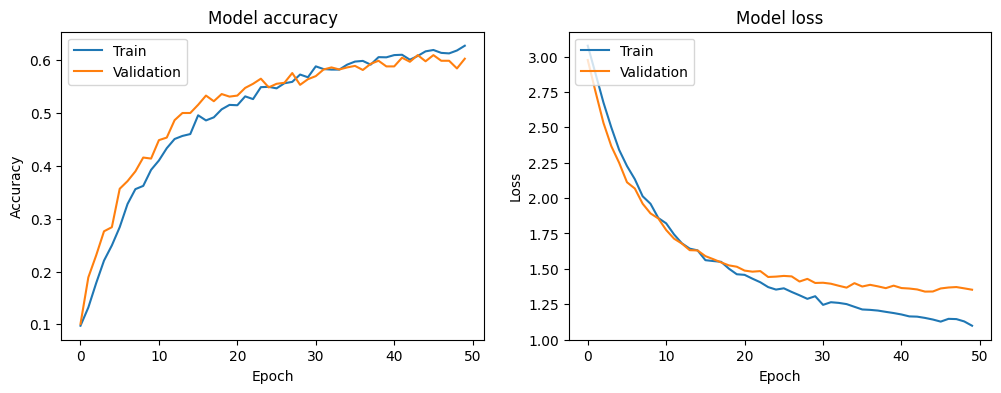

In [16]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

               precision    recall  f1-score   support

         baca      0.559     0.528     0.543        36
        bantu      0.885     0.697     0.780        33
        bapak      0.377     0.722     0.495        36
buangairkecil      0.923     0.667     0.774        18
         buat      0.642     0.872     0.739        39
         halo      0.800     0.667     0.727        54
          ibu      0.600     0.500     0.545        12
         kamu      0.595     0.439     0.505        57
         maaf      0.897     0.648     0.753        54
        makan      0.786     0.524     0.629        42
          mau      0.745     0.745     0.745        51
         nama      0.556     0.556     0.556        54
         pagi      0.544     0.717     0.619        60
        paham      0.467     0.833     0.599        60
        sakit      0.714     0.556     0.625         9
    sama-sama      0.627     0.693     0.658        75
         saya      0.636     0.389     0.483        18
      sel

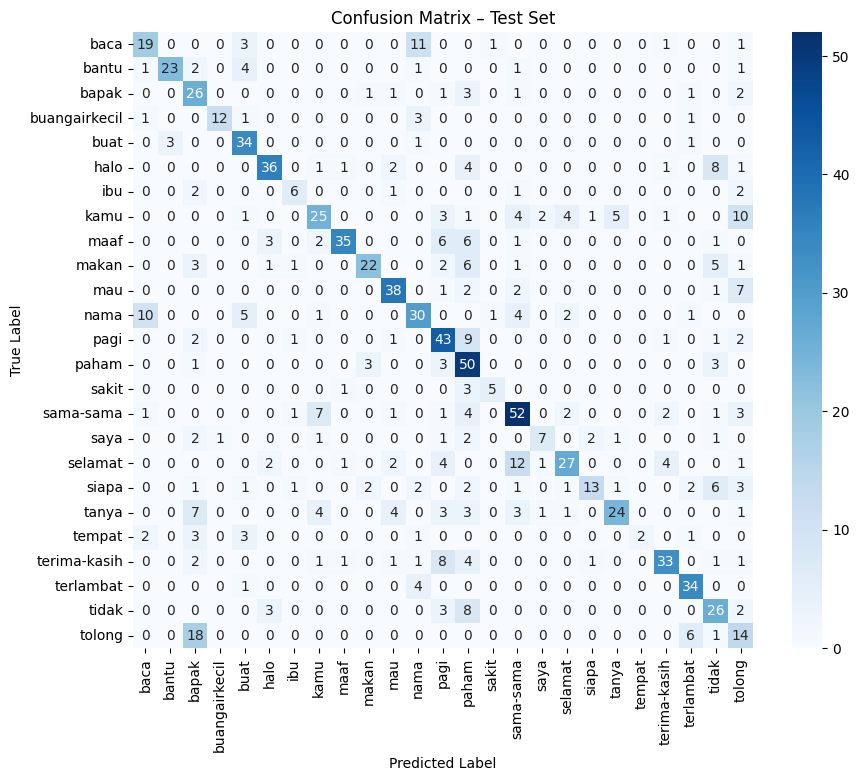

In [17]:
y_true, y_pred = [], []
target_names = [label_map[i] for i in range(len(label_map))]
for X_batch, y_batch in test_ds:
    y_true.append(y_batch.numpy())

    batch_pred = cnn_model.predict(X_batch, verbose=0)
    y_pred.append(np.argmax(batch_pred, axis=1))

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

print(classification_report(
    y_true, y_pred,
    digits=3,                            
    target_names=target_names 
))

cm = confusion_matrix(y_true, y_pred, labels=range(len(label_map)))
labels = [label_map[i] for i in range(len(label_map))]

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix – Test Set")
plt.show()